In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import seaborn as sns
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorSamples, PosteriorCoverage, PlotSinglePosterior
import h5py
from sklearn.decomposition import PCA
# from funcs import *
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


In [98]:
ids_train=np.load("/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zwst/ids_train.npy").astype(int)
ids_val=np.load("/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zwst/ids_val.npy").astype(int)
ids_test=np.load("/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/models/halo/zwst/ids_test.npy").astype(int)

In [48]:
params_set=["Omega_m", "Omega_b", "h", "n_s", "sigma_8"]
params=params_set[:]
test_x, test_theta=process_data(data=test_set)

In [5]:
abacuslike=pd.read_csv("Dataset/abacuslike/fastpm/L2000-N256/zhalos.csv").set_index('id')

train_set=abacuslike.loc[ids_train]
val_set=abacuslike.loc[ids_val]
test_set=abacuslike.loc[ids_test]

abacus_nbody_set=pd.read_csv("Dataset/abacus/nbody/L2000-N256/zhalos.csv").set_index('id')
abacus_fastpm_set=pd.read_csv("Dataset/abacus/fastpm/L2000-N256/zhalos.csv").set_index('id')

params_set=["Omega_m", "Omega_b", "h", "n_s", "sigma_8"]
params=params_set[:]
# params=["Omega_m", "sigma_8"]

In [69]:
np.save("/anvil/scratch/x-abairagi/cmass-ili/abacus/nbody/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/ids_test.npy", ids_test)

In [91]:
# train_set[params].max(0)
abacus_set[params].max(0)
# [0.1, 0.02, 0.5, 0.8, 0.6], high=[0.5, 0.08, 0.9, 1.2, 1]

Omega_m    0.388107
Omega_b    0.059567
h          0.716500
n_s        1.024900
sigma_8    0.905163
dtype: float64

In [22]:
def process_data(data):

    s0=np.array([h5py.File(i)['zS0'][()].astype(np.float64).flatten() for i in data['Filename']])
    s12=np.array([h5py.File(i)['zS12'][()].astype(np.float64).flatten() for i in data['Filename']])
    
    # s0=np.array([np.load(i).astype(np.float64).flatten() for i in data['S0']])
    # s12=np.array([np.load(i).astype(np.float64).flatten() for i in data['S12']])
    
    x=np.concatenate([s0,s12],1)
    x=np.log(x)
    theta=data[params].values
    
    return x, theta

In [8]:
train_x, train_theta=process_data(data=train_set)
val_x, val_theta=process_data(data=val_set)
test_x, test_theta=process_data(data=test_set)

abacus_nbody_x, abacus_nbody_theta=process_data(data=abacus_nbody_set)
abacus_fastpm_x, abacus_fastpm_theta=process_data(data=abacus_fastpm_set)

In [39]:
pca = PCA(n_components=100)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)
abacus_nbody_x = pca.transform(abacus_nbody_x)
abacus_fastpm_x = pca.transform(abacus_fastpm_x)
explained_variance = pca.explained_variance_ratio_

In [40]:
# mean=fid_x.mean(axis=0)
# std=fid_x.std(axis=0)
# train_x=(train_x-mean)/std
# test_x=(test_x-mean)/std
# fid_x = (fid_x-mean)/std

In [9]:
# make a dataloader
loader = NumpyLoader(x=train_x, theta=train_theta)

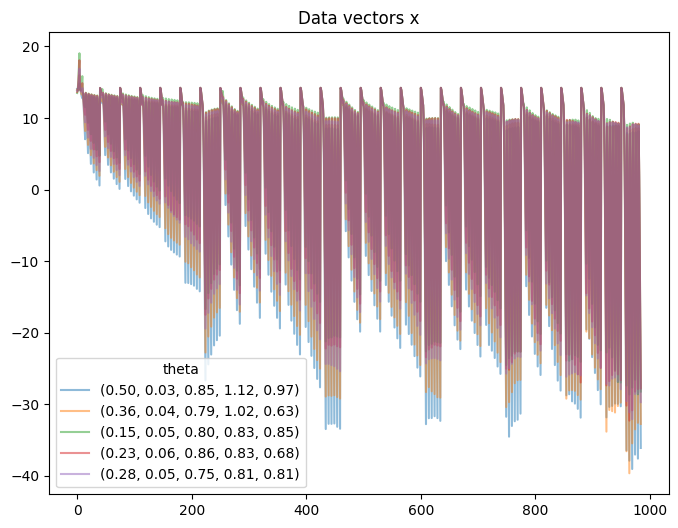

In [27]:
# plot some examples of the data
x=train_x
theta=train_theta
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [10]:
# theta=train_theta_pmwd
# define a prior
# prior = ili.utils.Uniform(low=[theta[:,0].min(), theta[:,1].min(), theta[:,2].min(), theta[:,3].min(), theta[:,4].min()], high=[theta[:,0].max(), theta[:,1].max(), theta[:,2].max(), theta[:,3].max(), theta[:,4].max()], device=device)
prior = ili.utils.Uniform(low=[0.1, 0.02, 0.5, 0.8, 0.6], high=[0.5, 0.08, 0.9, 1.2, 1], device=device)
# prior = ili.utils.Uniform(low=[theta[:,0].min(), theta[:,1].min()], high=[theta[:,0].max(), theta[:,1].max()], device=device)
# prior = ili.utils.Uniform(low=[0.1, 0.6], high=[0.5, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    # ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 16,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [11]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 100

INFO:root:It took 55.13527464866638 seconds to train models.


 Neural network successfully converged after 101 epochs.

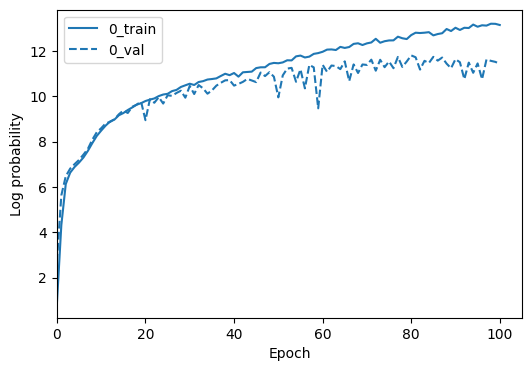

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [26]:
test_set.iloc[68]['Filename']

'/anvil/scratch/x-abairagi/cmass-ili/abacuslike/fastpm/L2000-N256/663/diag/halos_wst.h5'

Drawing 1000 posterior samples: 1050it [00:00, 12841.24it/s]            


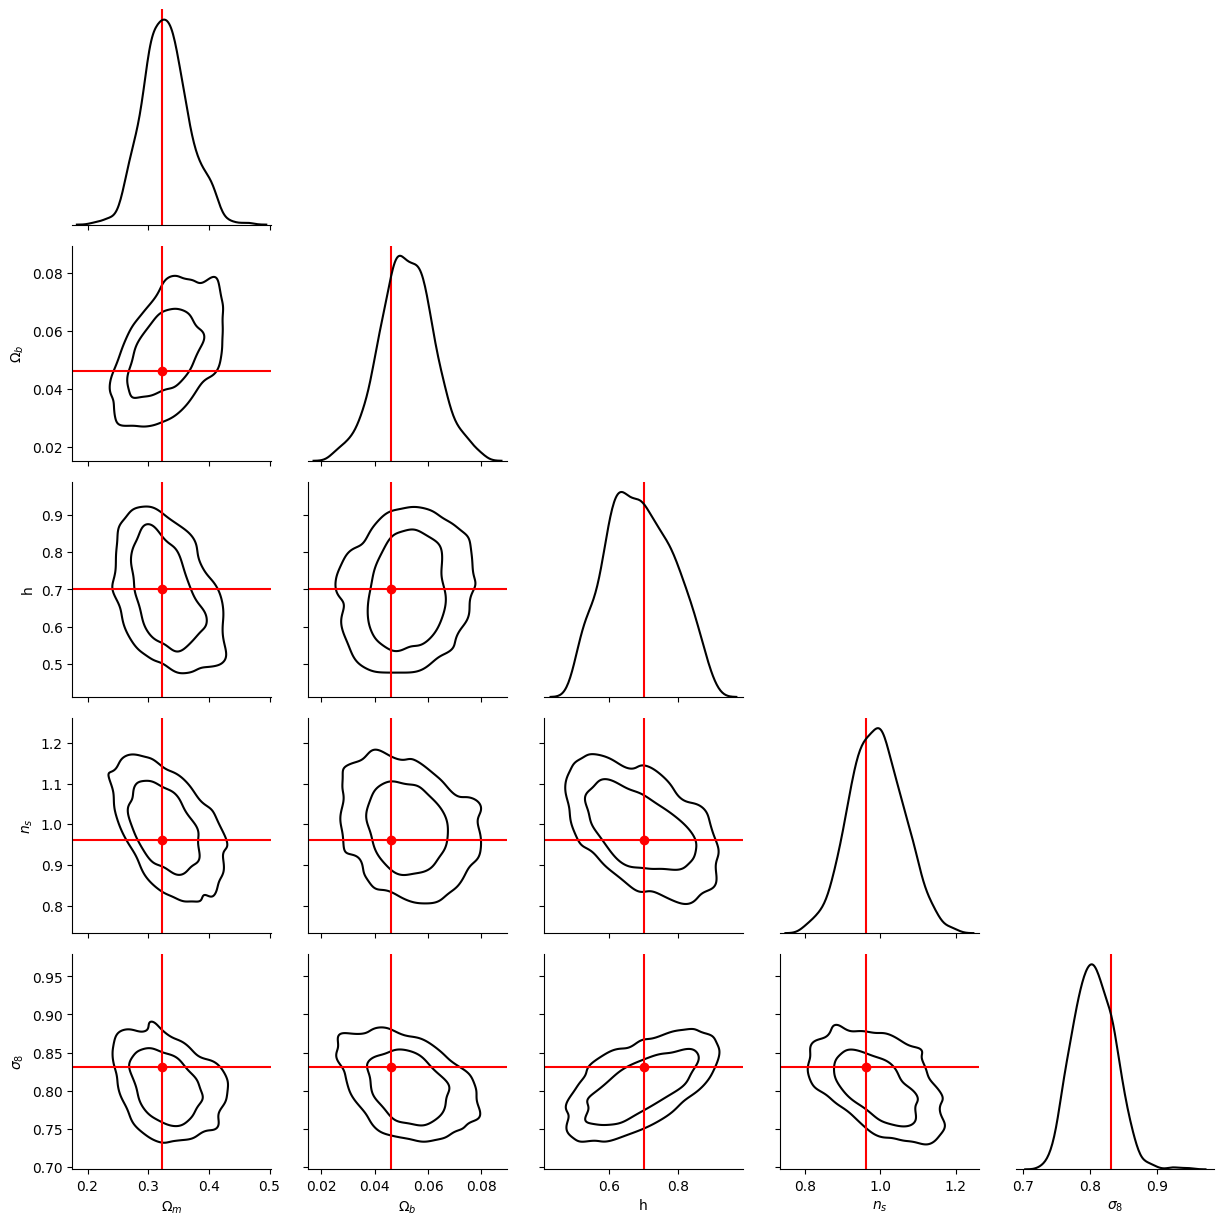

In [27]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)
ind=68
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_x[ind], theta_fid=test_theta[ind]
)

Drawing 1000 posterior samples: 1035it [00:00, 12750.67it/s]            


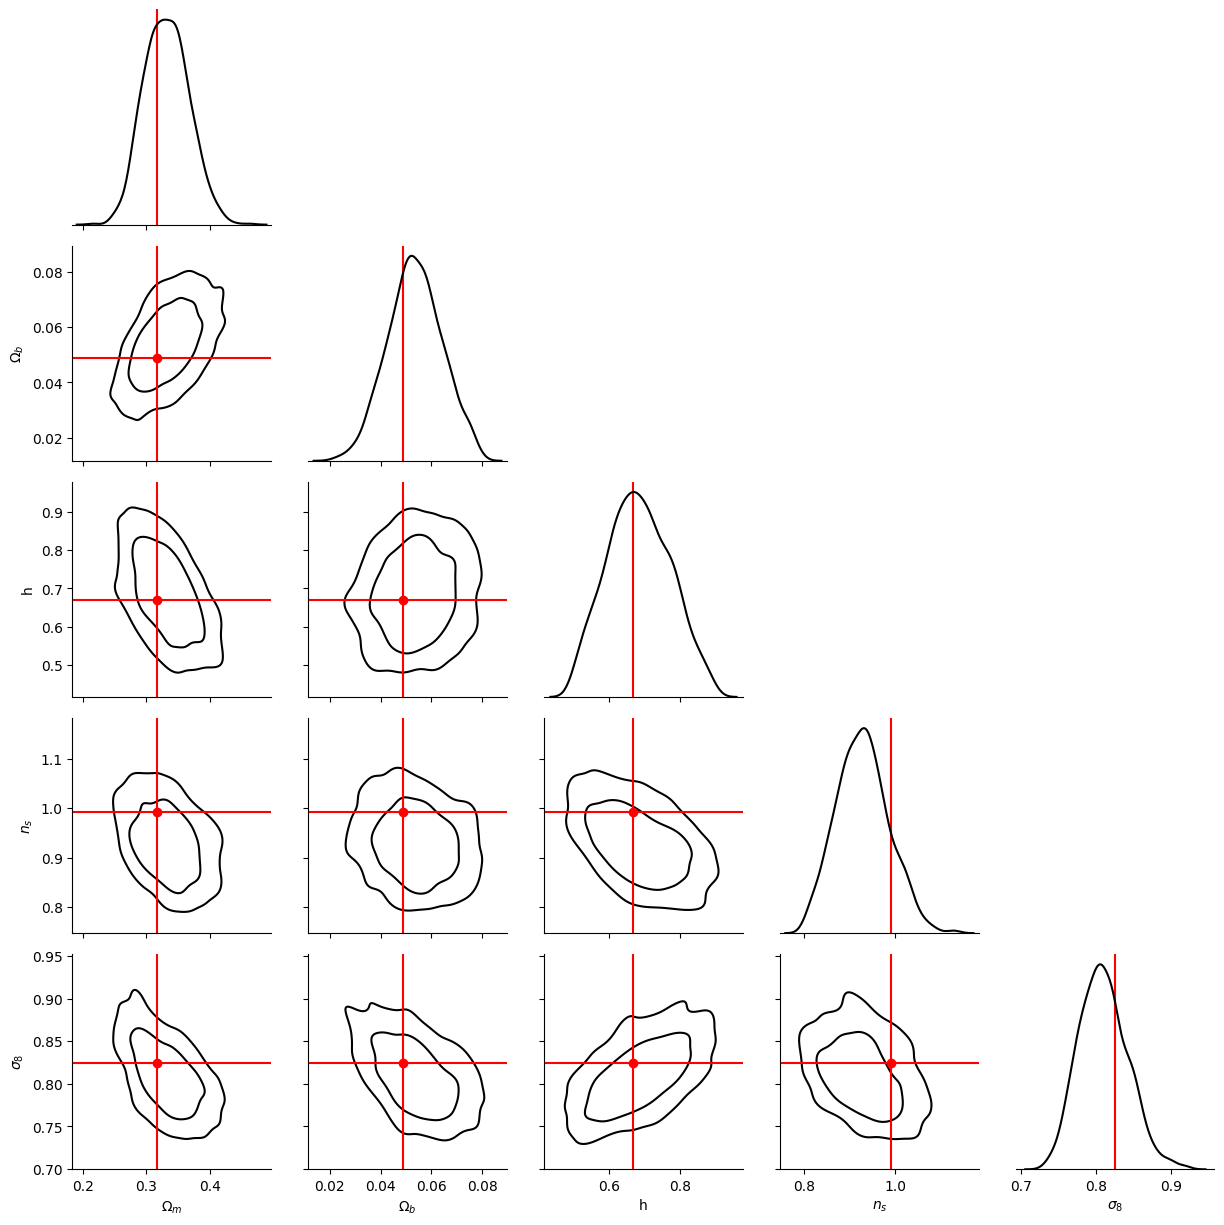

In [30]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)
ind=0
fig = metric(
    posterior=posterior_ensemble,
    x_obs = abacus_nbody_x[ind], theta_fid=abacus_nbody_theta[ind],
)

Drawing 1000 posterior samples: 1033it [00:00, 13055.15it/s]            
Drawing 1000 posterior samples: 1046it [00:00, 9365.68it/s]             


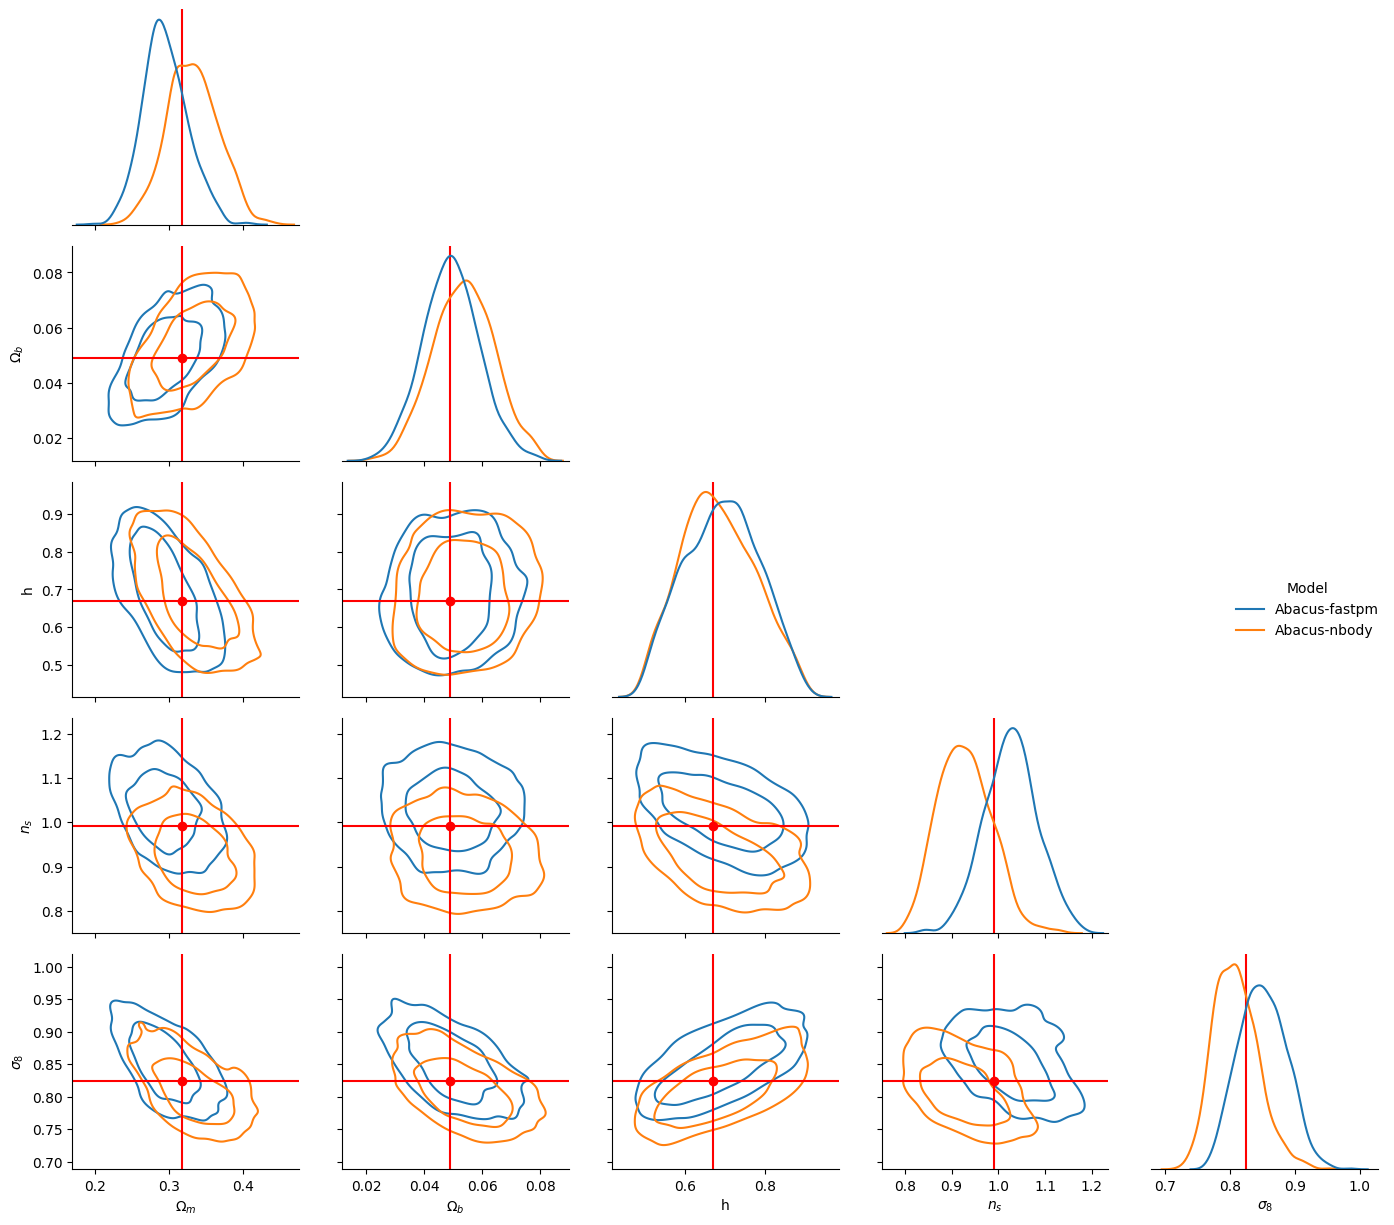

In [42]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)

fig = metric(
    posterior=posterior_ensemble,
    x_obs = abacus_fastpm_x[1], theta_fid=abacus_fastpm_theta[1],
    name = 'Abacus-fastpm'
)

fig = metric(
    posterior=posterior_ensemble,
    x_obs = abacus_nbody_x[0], theta_fid=abacus_nbody_theta[0],
    name = 'Abacus-nbody',
    grid = fig
)

100%|██████████| 197/197 [00:20<00:00,  9.78it/s]
INFO:root:Mean logprob: 1.1403e+01Median logprob: 1.2132e+01
100%|██████████| 100/100 [00:01<00:00, 68.66it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


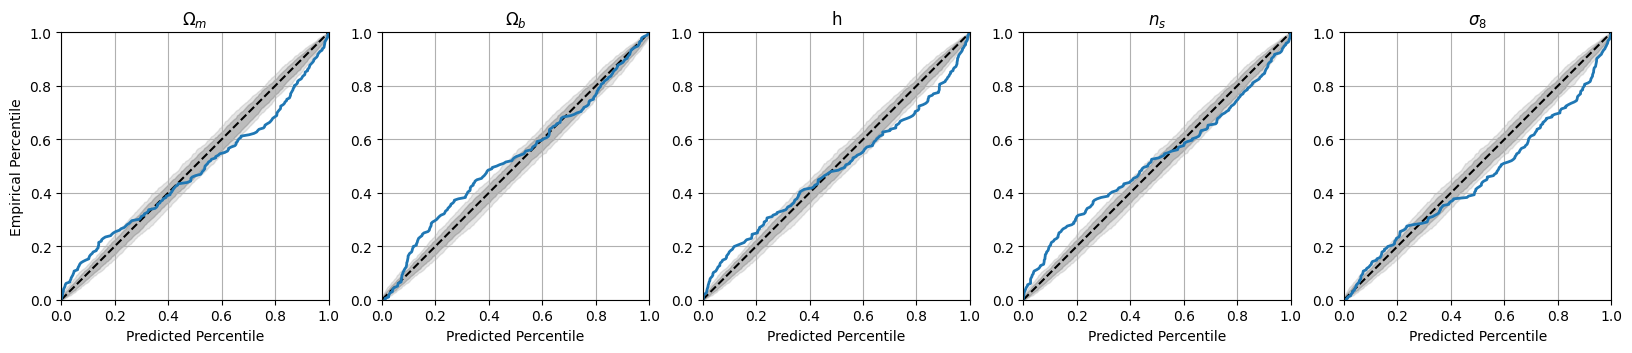

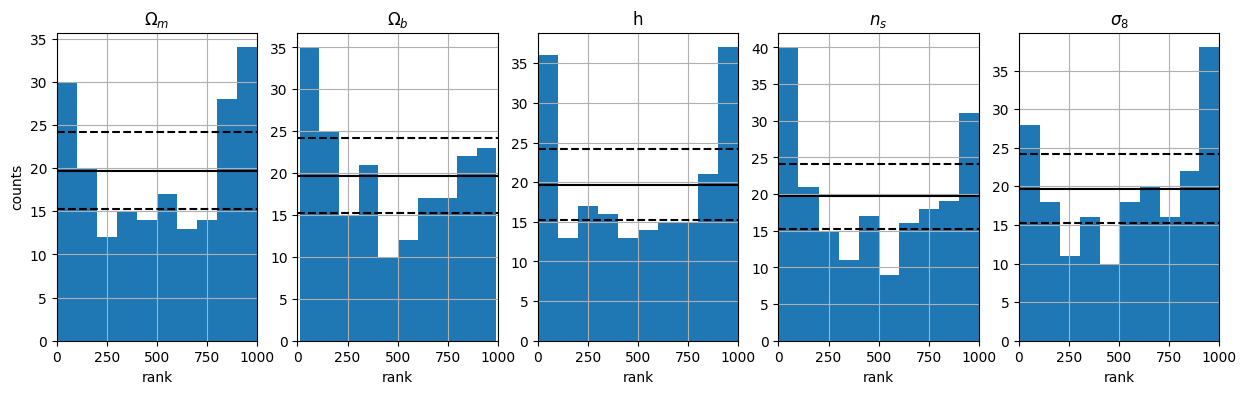

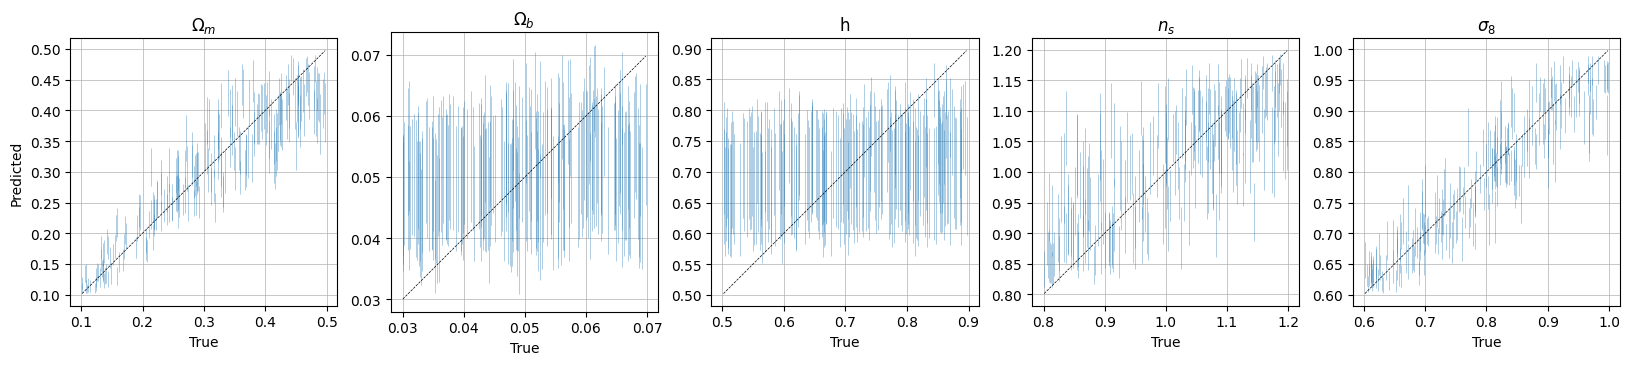

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


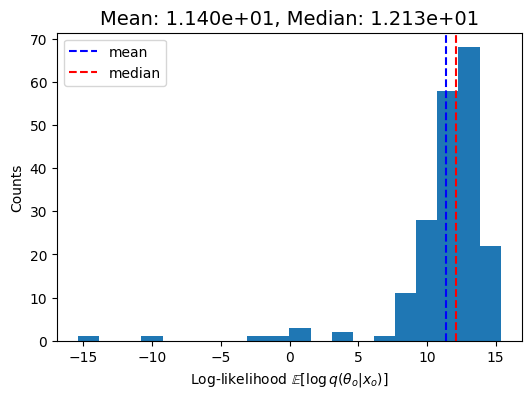

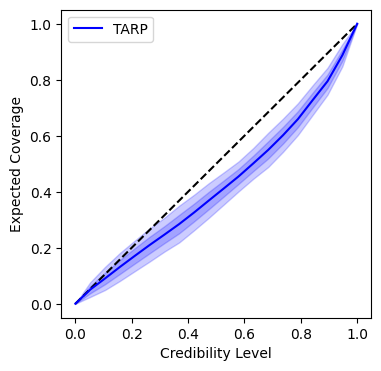

In [44]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=posterior_ensemble,
#     .posteriors[0],
    x=test_x, theta=test_theta
)

100%|██████████| 20/20 [00:01<00:00, 11.80it/s]
INFO:root:Mean logprob: 5.5683e+00Median logprob: 4.7831e+00
100%|██████████| 100/100 [00:00<00:00, 611.88it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


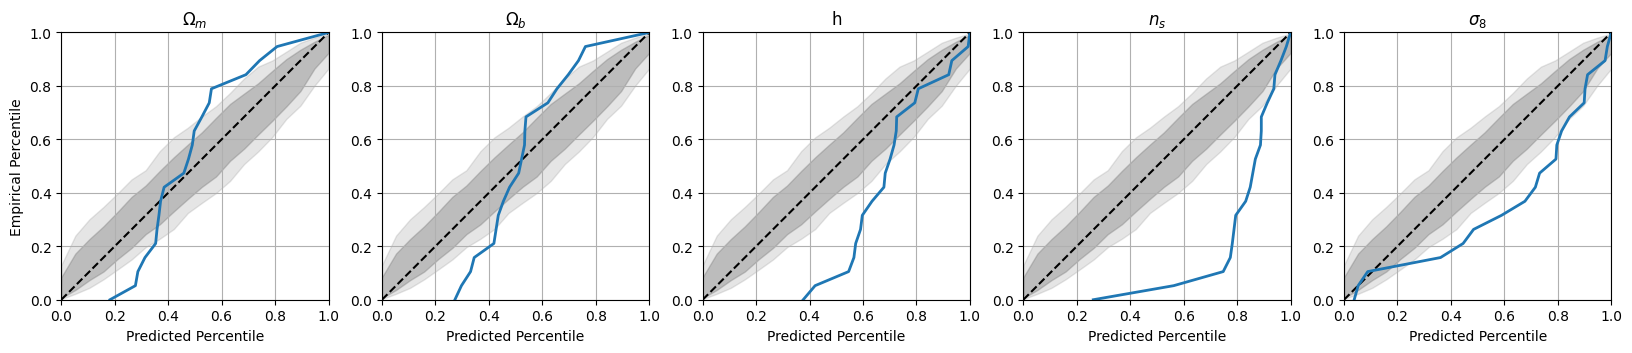

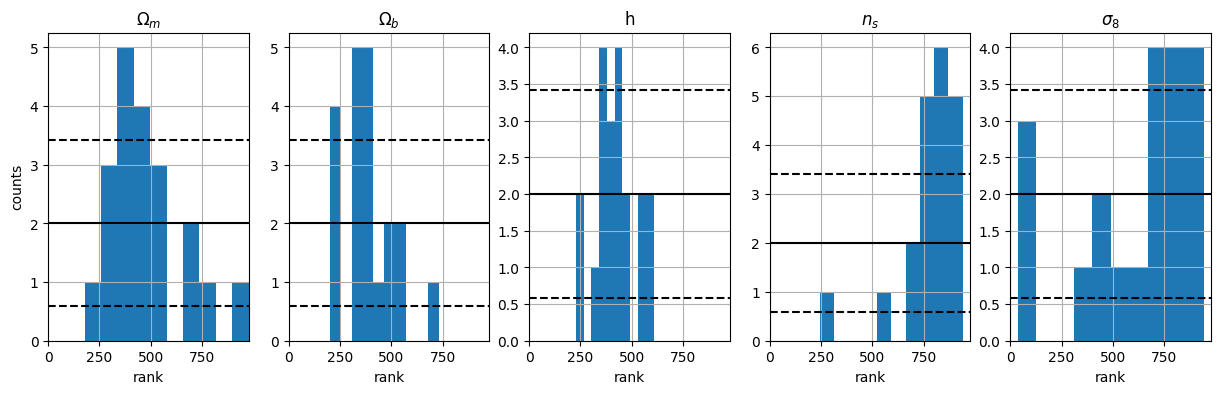

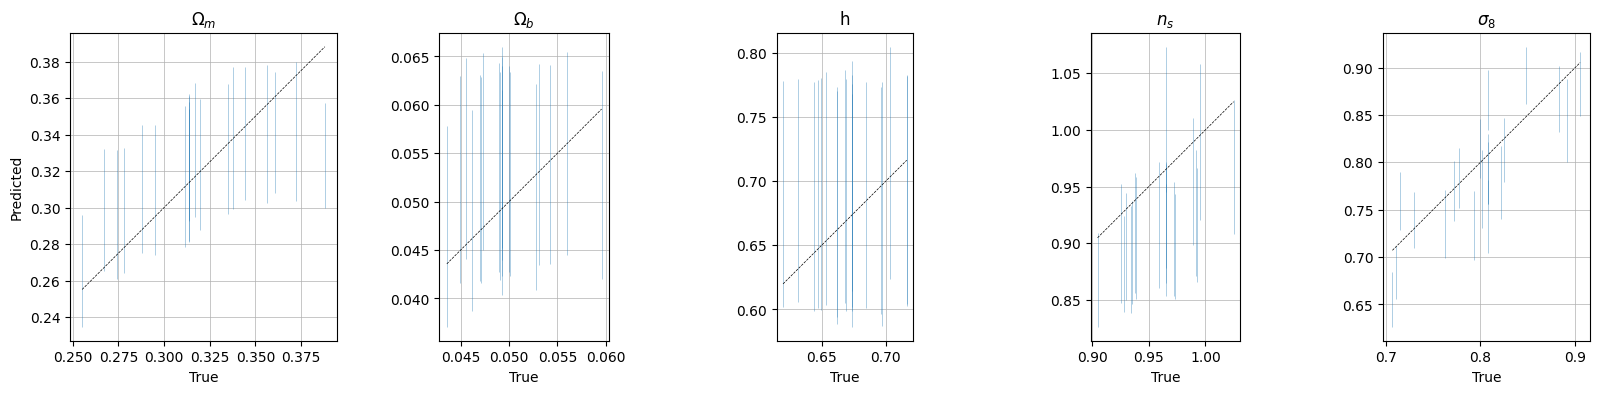

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


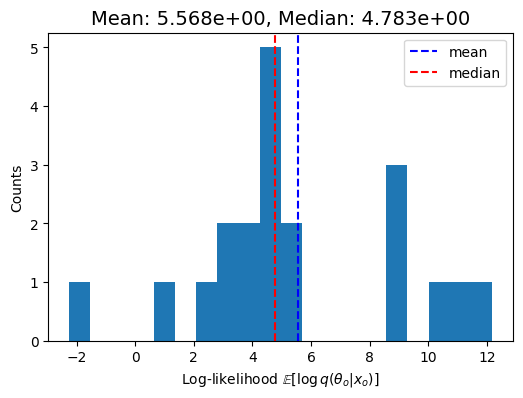

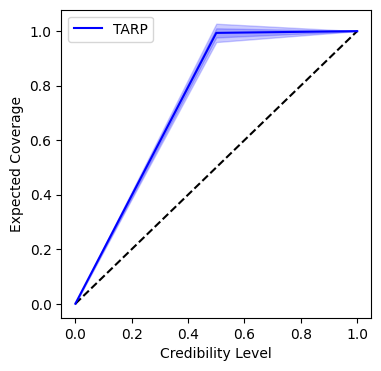

In [45]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=posterior_ensemble,
#     .posteriors[0],
    x=abacus_nbody_x, theta=abacus_nbody_theta
)

100%|██████████| 52/52 [00:04<00:00, 12.08it/s]
INFO:root:Mean logprob: 1.3025e+01Median logprob: 1.3516e+01
100%|██████████| 100/100 [00:00<00:00, 270.69it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


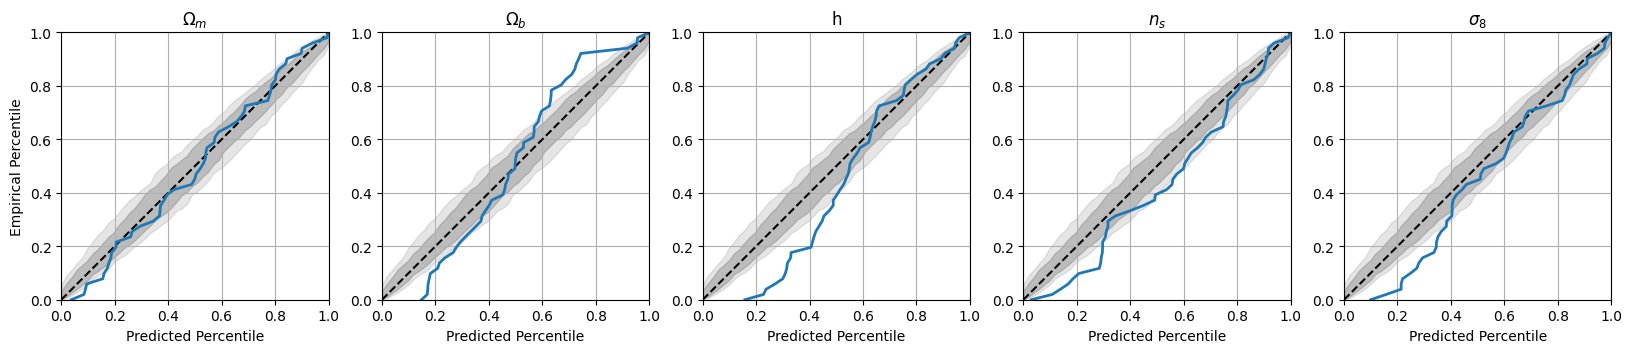

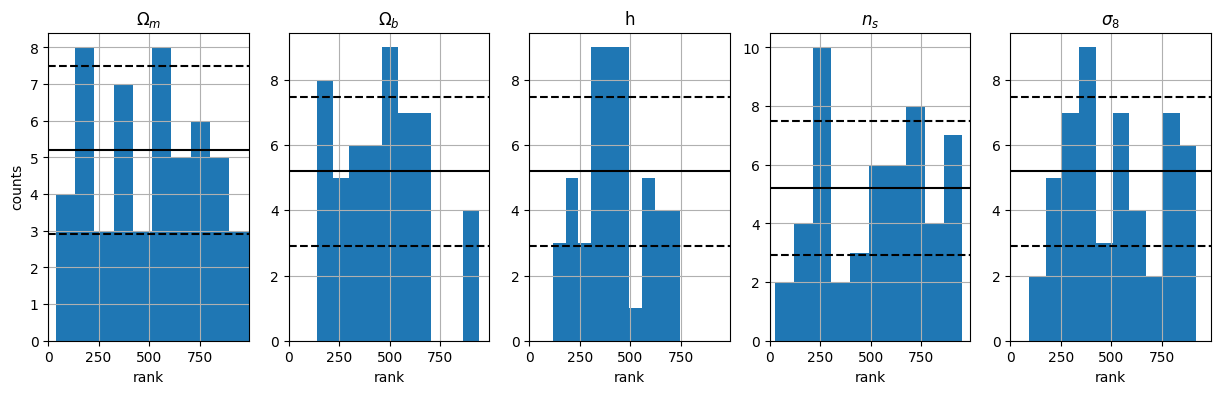

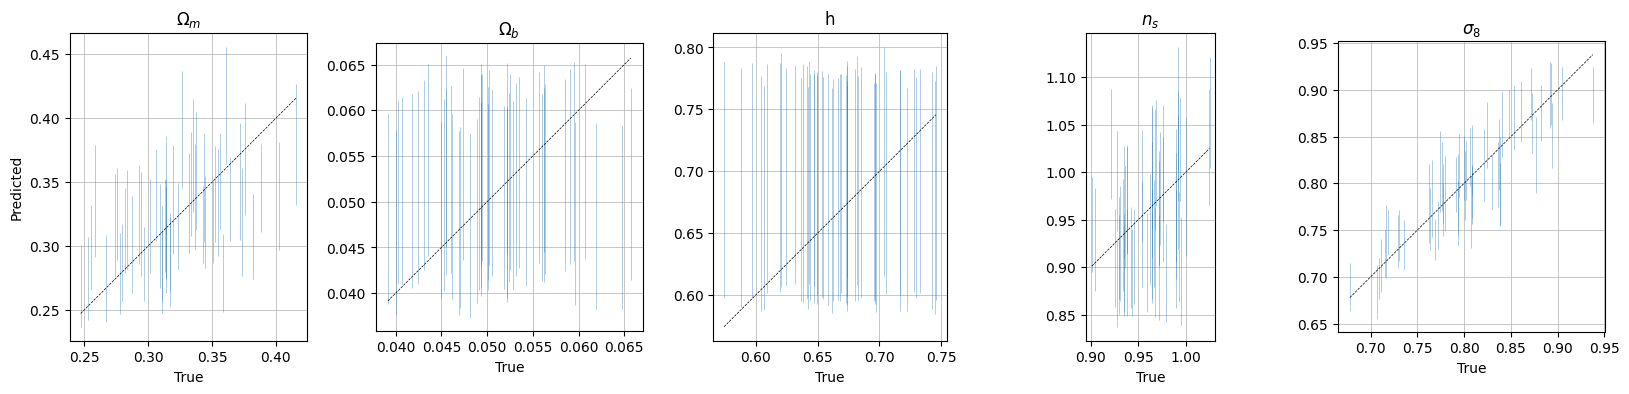

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


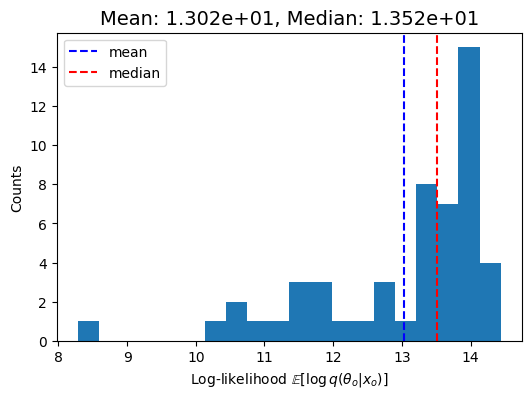

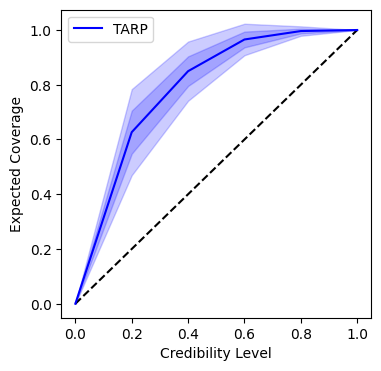

In [46]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=posterior_ensemble,
#     .posteriors[0],
    x=abacus_fastpm_x, theta=abacus_fastpm_theta
)

In [82]:
def get_ranks(
    samples: np.array,
    trues: np.array,
    weights: np.array = None
) -> np.array:
    """Get the marginal ranks of the true parameters in the posterior samples.
    modified from ltu_ili to include weights

    Args:
        samples (np.array): posterior samples of shape (nsamples, ndata, npars)
        trues (np.array): true parameters of shape (ndata, npars)

    Returns:
        np.array: ranks of the true parameters in the posterior samples
            of shape (ndata, npars)
    """

    if weights is not None:
        weights = weights / weights.sum(axis=0) * len(weights)
        weights = np.stack([weights] * samples.shape[-1], axis=-1)
        weights[samples > trues[None, ...]] = 0
        ranks = weights.sum(axis=0)


    else:
        ranks = (samples < trues[None, ...]).mean(axis=0)
    return ranks
def get_coverage_sample(Pk_obs,true_params,posterior_ensemble,n_raw_samples=10000):
    '''
    Plot the coverage of predicted percentiles against empirical percentiles.
    reweight the samples to consider the h^2 scaling of the prior

    Args:
        Pk_obs (np.array): observed power spectrum
        true_params (np.array): true parameters. Should be in the form of [Omega_m, Omega_b, h, n_s, sigma8]
        posterior_ensemble (nn.Module): ensemble of posterior
        n_raw_samples (int): number of raw samples to draw from posterior, will be downsampled after prior cut

    Returns:
        matplotlib.figure.Figure: The generated figure.

    '''

    total_pos_samples = np.zeros((n_raw_samples,true_params.shape[0],true_params.shape[1]))

    for i in range(true_params.shape[0]):
        total_pos_samples[:,i,:] = posterior_ensemble.sample((n_raw_samples,),x= Pk_obs[i],show_progress_bars=False).detach().cpu().numpy()

    #transform true_params to original space
    true_params_ori =true_params.copy()
    true_params_ori[:,:2]*=true_params_ori[:,2][:,np.newaxis]**2

    #get the prior range
    low = true_params_ori.min(axis=0)
    high = true_params_ori.max(axis=0)

    #transform total_pos_samples to original space
    total_pos_samples_ori = total_pos_samples.copy()
    total_pos_samples_ori[:,:,0] = total_pos_samples_ori[:,:,0]*total_pos_samples_ori[:,:,2]**2
    total_pos_samples_ori[:,:,1] = total_pos_samples_ori[:,:,1]*total_pos_samples_ori[:,:,2]**2

    #remove samples in total_pos_samples outside of prior range
    clipped_pos_samples = []
    min_samples = np.inf
    for i in range(total_pos_samples_ori.shape[1]):
        mask = (total_pos_samples_ori[:,i,:] > low).all(axis=1) & (total_pos_samples_ori[:,i,:] < high).all(axis=1)
        clipped_pos_samples.append(total_pos_samples_ori[:,i,:][mask])
        min_samples = min(min_samples,len(clipped_pos_samples[-1]))


    #downsmaple to min_samples samples
    for i in range(len(clipped_pos_samples)):
        clipped_pos_samples[i] = clipped_pos_samples[i][np.random.choice(clipped_pos_samples[i].shape[0],min_samples,replace=False)]

    clipped_pos_samples = np.array(clipped_pos_samples)
    clipped_pos_samples= clipped_pos_samples.transpose(1,0,2)

    #transform samples back to inference space
    clipped_pos_samples[:,:,0] = clipped_pos_samples[:,:,0]/clipped_pos_samples[:,:,2]**2
    clipped_pos_samples[:,:,1] = clipped_pos_samples[:,:,1]/clipped_pos_samples[:,:,2]**2

    #get weights of each sample (this is obtained from calculating the jacobian of the transformation)
    weights = clipped_pos_samples[:,:,2]**4

    return clipped_pos_samples,weights

def plot_coverage(
    samples: np.ndarray, trues: np.ndarray,
    signature: str, plotscatter: bool = True,weights=None,
    labels = [r'$\log \zeta$',r'$\log T_{vir}$'],fontsize=12
) -> plt.Figure:
    """
    Plot the coverage of predicted percentiles against empirical percentiles.
    modified from ltu_ili to include weights

    Args:
        samples (numpy.ndarray): Array of predicted samples.
        trues (numpy.ndarray): Array of true values.
        signature (str): Signature for the plot file name.
        plotscatter (bool, optional): Whether to plot the scatter plot. Defaults to True.

    Returns:
        matplotlib.figure.Figure: The generated figure.

    """
    ndata, npars = trues.shape
    ranks = get_ranks(samples, trues,weights=weights)

    unicov = [np.sort(np.random.uniform(0, 1, ndata)) for j in range(200)]
    unip = np.percentile(unicov, [5, 16, 84, 95], axis=0)

    #set overall font size
    plt.rcParams.update({'font.size': fontsize})

    fig, ax = plt.subplots(1, npars, figsize=(npars * 4, 4),sharey=True,sharex=True)
    if npars == 1:
        ax = [ax]
    cdf = np.linspace(0, 1, len(ranks))
    for i in range(npars):
        xr = np.sort(ranks[:, i])
        xr = xr / xr[-1]
        ax[i].plot(cdf, cdf, 'k--')
        if plotscatter:
            ax[i].fill_between(cdf, unip[0], unip[-1],
                                color='gray', alpha=0.2)
            ax[i].fill_between(cdf, unip[1], unip[-2],
                                color='gray', alpha=0.4)
        ax[i].plot(xr, cdf, lw=2, label='posterior')
        ax[i].set(adjustable='box', aspect='equal')
        ax[i].set_title(labels[i], fontsize=fontsize*1.8)
        ax[i].set_xlabel('Predicted Percentile')
        ax[i].set_xlim(0, 1)
        ax[i].set_ylim(0, 1)

    ax[0].set_ylabel('Empirical Percentile')
    # for axis in ax:
    #     axis.grid(visible=True)

    return fig

def plot_coverage_with_h_square(Pk_obs,true_params,posterior_ensemble,n_raw_samples=10000):
    '''
    Plot the coverage of predicted percentiles against empirical percentiles.
    reweight the samples to consider the h^2 scaling of the prior

    Args:
        Pk_obs (np.array): observed power spectrum
        true_params (np.array): true parameters. Should be in the form of [Omega_m, Omega_b, h, n_s, sigma8]
        posterior_ensemble (nn.Module): ensemble of posterior
        n_raw_samples (int): number of raw samples to draw from posterior, will be downsampled after prior cut

    Returns:
        matplotlib.figure.Figure: The generated figure.

    '''

    total_pos_samples = np.zeros((n_raw_samples,true_params.shape[0],true_params.shape[1]))

    for i in range(true_params.shape[0]):
        total_pos_samples[:,i,:] = posterior_ensemble.sample((n_raw_samples,),x= Pk_obs[i],show_progress_bars=False).detach().cpu().numpy()

    #transform true_params to original space
    true_params_ori =true_params.copy()
    true_params_ori[:,:2]*=true_params_ori[:,2][:,np.newaxis]**2

    #get the prior range
    low = true_params_ori.min(axis=0)
    high = true_params_ori.max(axis=0)

    #transform total_pos_samples to original space
    total_pos_samples_ori = total_pos_samples.copy()
    total_pos_samples_ori[:,:,0] = total_pos_samples_ori[:,:,0]*total_pos_samples_ori[:,:,2]**2
    total_pos_samples_ori[:,:,1] = total_pos_samples_ori[:,:,1]*total_pos_samples_ori[:,:,2]**2

    weights_clip = np.zeros((n_raw_samples,true_params.shape[0]))
    #remove samples in total_pos_samples outside of prior range
    for i in range(total_pos_samples_ori.shape[1]):
        mask = (total_pos_samples_ori[:,i,:] > low).all(axis=1) & (total_pos_samples_ori[:,i,:] < high).all(axis=1)
        weights_clip[:,i] = mask.astype(int)

    #transform samples back to inference space
    total_pos_samples_ori[:,:,0] = total_pos_samples_ori[:,:,0]/total_pos_samples_ori[:,:,2]**2
    total_pos_samples_ori[:,:,1] = total_pos_samples_ori[:,:,1]/total_pos_samples_ori[:,:,2]**2

    #get weights of each sample (this is obtained from calculating the jacobian of the transformation)
    weights_h2 = total_pos_samples_ori[:,:,2]**4

    total_weights = weights_clip*weights_h2

    fig = plot_coverage(total_pos_samples_ori, true_params, 'coverage',weights=total_weights,labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'])

    return fig, total_pos_samples_ori, total_weights


In [92]:
abacus_set[params].max(0)

Omega_m    0.388107
Omega_b    0.059567
h          0.716500
n_s        1.024900
sigma_8    0.905163
dtype: float64

In [93]:
total_pos_samples_ori.max(0)

array([[0.49967739, 0.07856827, 0.89575964, 1.19947553, 0.92952406],
       [0.43662357, 0.07861191, 0.89923269, 1.1913048 , 0.77430993],
       [0.47355786, 0.07982814, 0.89996976, 1.19764996, 0.82492828],
       [0.49153763, 0.07975152, 0.89499623, 1.19840443, 0.86920381],
       [0.4998453 , 0.07975174, 0.89329761, 1.19838095, 0.97542304],
       [0.37109551, 0.07953425, 0.89873177, 1.19967616, 0.88231951],
       [0.4942072 , 0.07943615, 0.89894372, 1.19945562, 0.87265903],
       [0.38951534, 0.07694639, 0.89968401, 1.19531262, 0.98327523],
       [0.47207978, 0.07799732, 0.89782006, 1.19758964, 0.96685487],
       [0.46060172, 0.07795105, 0.89943683, 1.19359708, 0.93664169]])

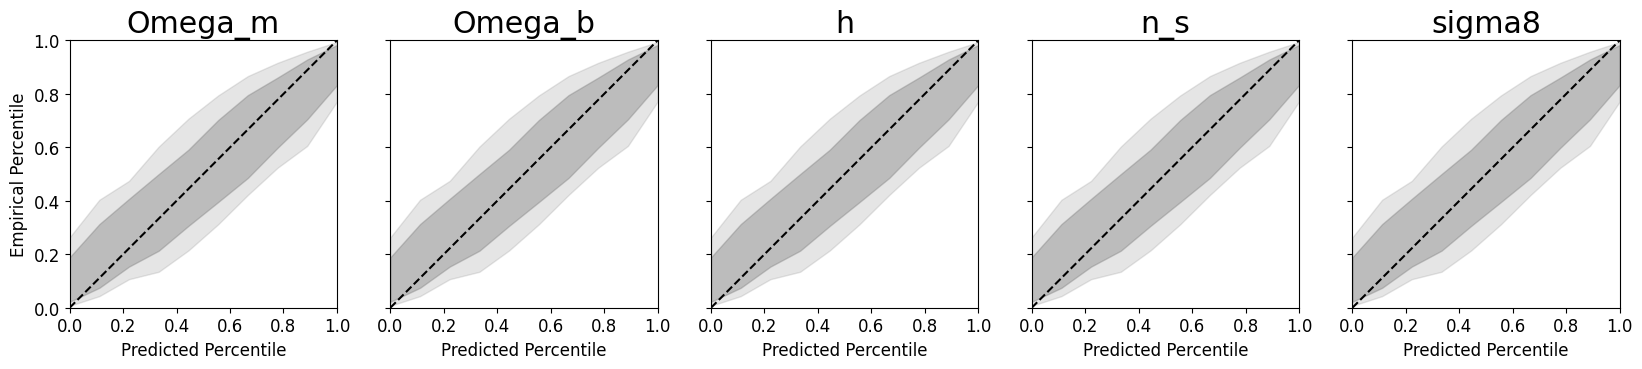

In [83]:
fig, total_pos_samples_ori, total_weights = plot_coverage_with_h_square(abacus_x[10:],abacus_theta[10:],posterior_ensemble,n_raw_samples=1000);

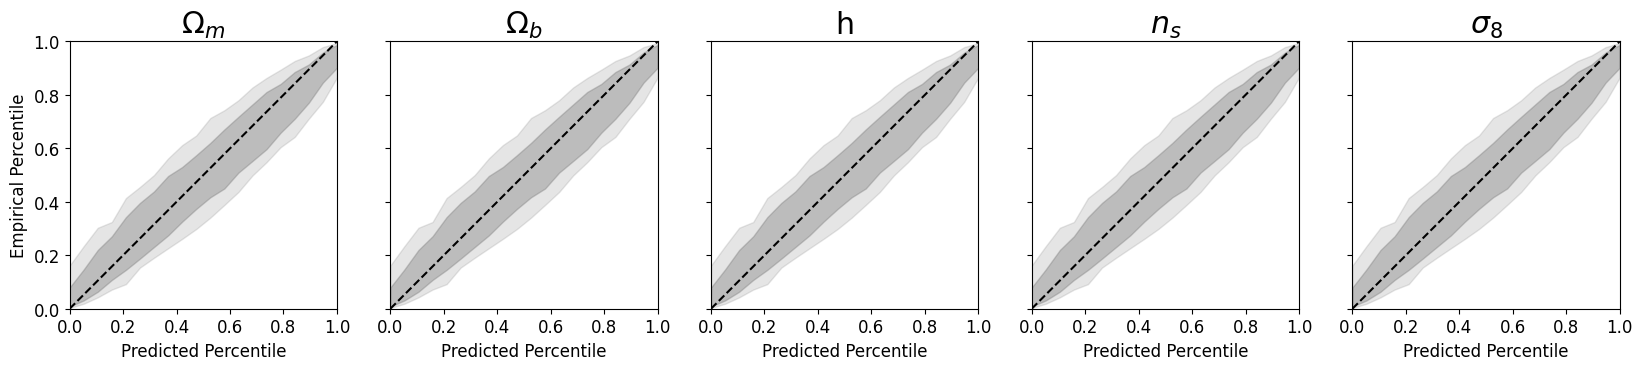

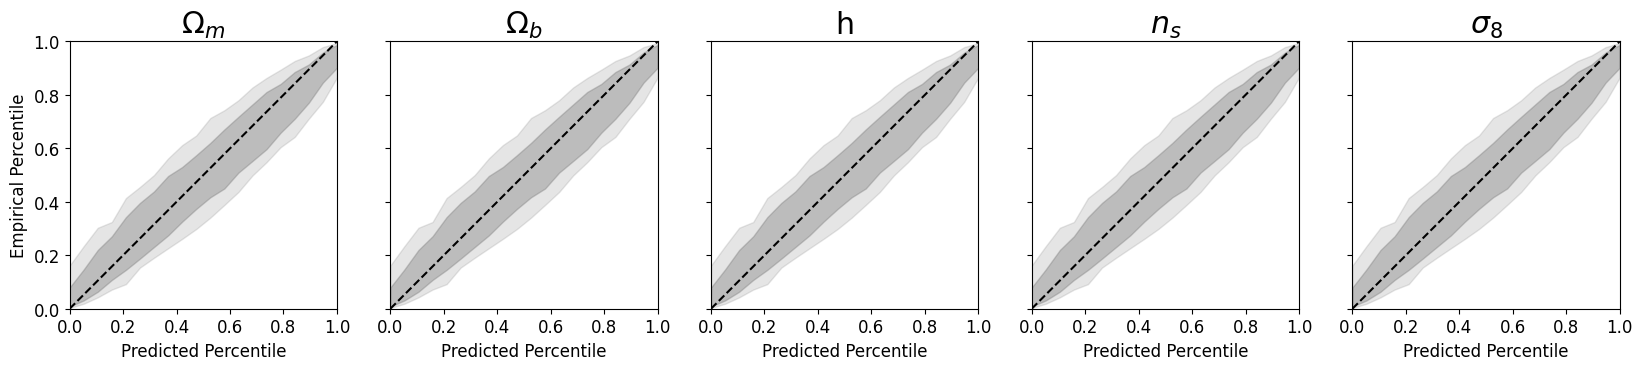

In [73]:
clipped_pos_samples,weights=get_coverage_sample(abacus_x,abacus_theta,posterior_ensemble,n_raw_samples=1000)
plot_coverage(
    samples= clipped_pos_samples, trues= abacus_theta,
    signature= "xyz", plotscatter=True,weights=weights,
    labels = ["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],fontsize=12
)

In [56]:
ps_matt=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/posterior_samples.npy")
matt_id=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/ids_test.npy")
matt_test_x=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/x_test.npy")
matt_test_theta=np.load("/anvil/scratch/x-mho1/cmass-ili/abacuslike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/theta_test.npy")

In [62]:
# choose a random input
ind = 68

# generate samples from the posterior using accept/reject sampling
# seed_samp = 32
# torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(test_x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(test_x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 1000 posterior samples: 1050it [00:00, 12538.85it/s]            


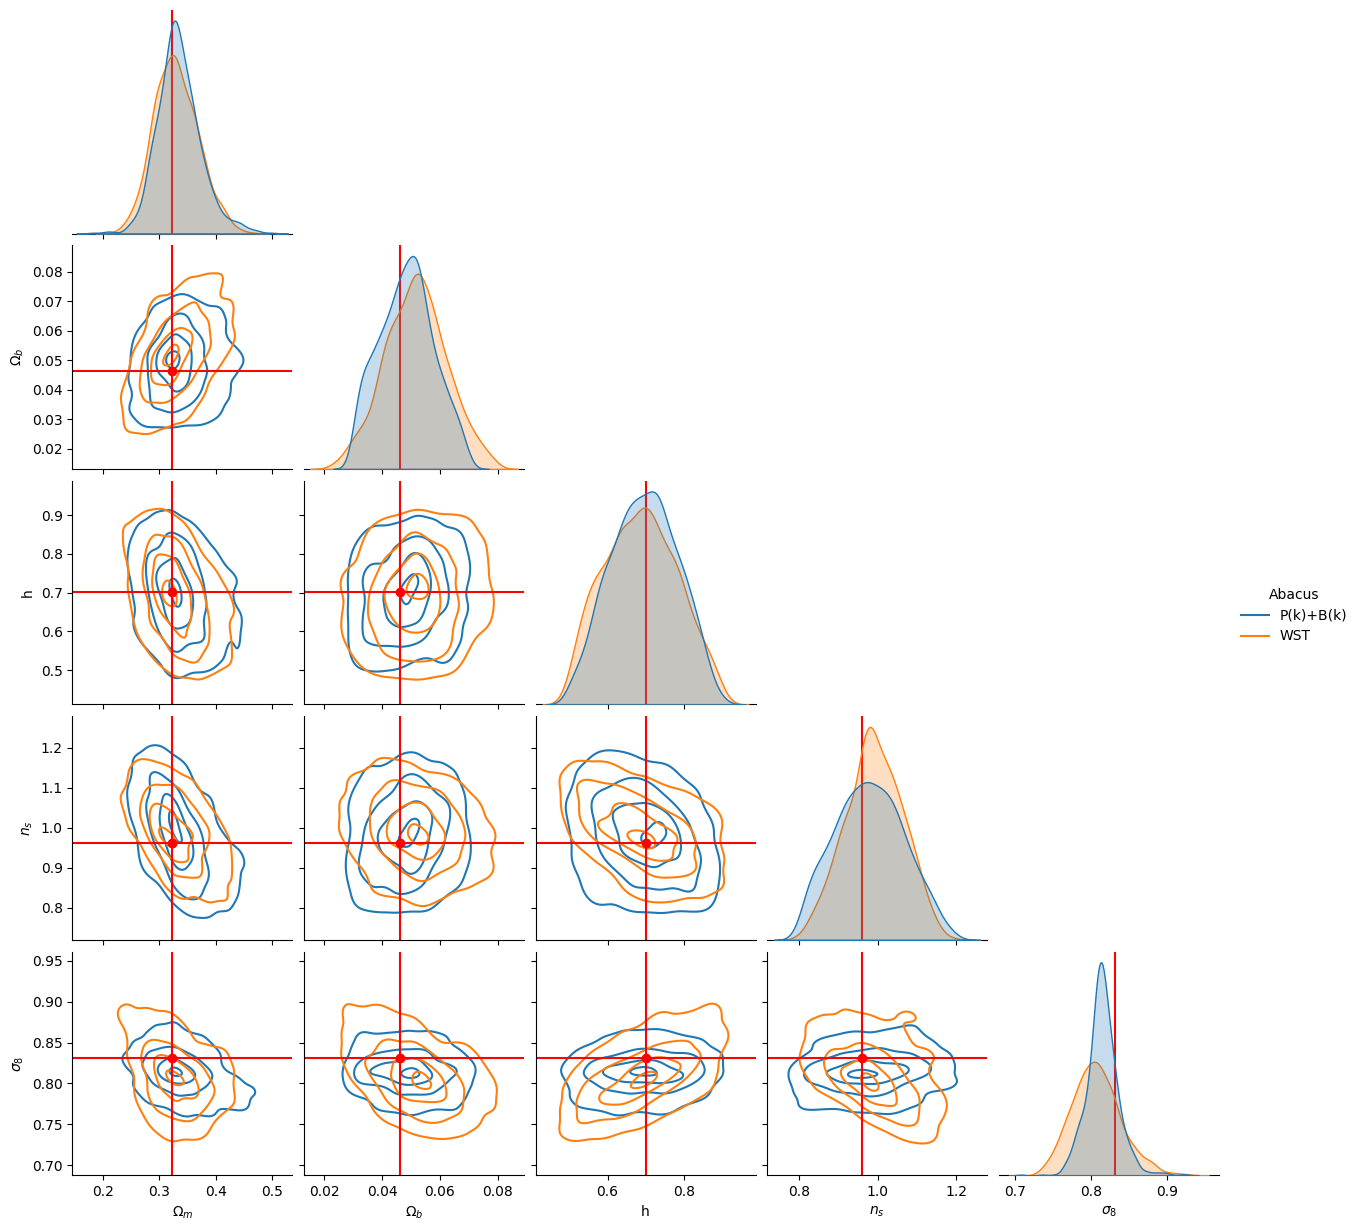

In [63]:
ind=68
df_matt=pd.DataFrame(ps_matt[:,ind], columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_ab=pd.DataFrame(samples, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_matt["Abacus"]="P(k)+B(k)"
df_ab["Abacus"]="WST"
df = pd.concat([df_matt, df_ab])
theta = matt_test_theta[ind]
fig=sns.pairplot(df, kind="kde", corner=True, hue="Abacus", plot_kws=dict(common_norm=False, levels=[0.05, 0.32, 0.68, 0.95]))
    
for i in range(5):
    for j in range(i + 1):
        if i == j:
            fig.axes[i, i].axvline(theta[i], color="r")
        else:
            fig.axes[i, j].axhline(theta[i], color="r")
            fig.axes[i, j].axvline(theta[j], color="r")
            fig.axes[i, j].plot(theta[j], theta[i], "ro")
            

In [57]:
samples

array([[0.4298866 , 0.05059568, 0.775807  , 0.93170536, 0.79379565],
       [0.3711693 , 0.04894958, 0.74145234, 1.0479339 , 0.7568283 ],
       [0.41575307, 0.06274018, 0.7883466 , 0.97274345, 0.77653754],
       ...,
       [0.33765593, 0.03491286, 0.7852314 , 1.0405215 , 0.78116214],
       [0.34673625, 0.04734814, 0.78611314, 1.0473156 , 0.7764883 ],
       [0.39344332, 0.03658608, 0.61594546, 1.0783783 , 0.7636069 ]],
      dtype=float32)

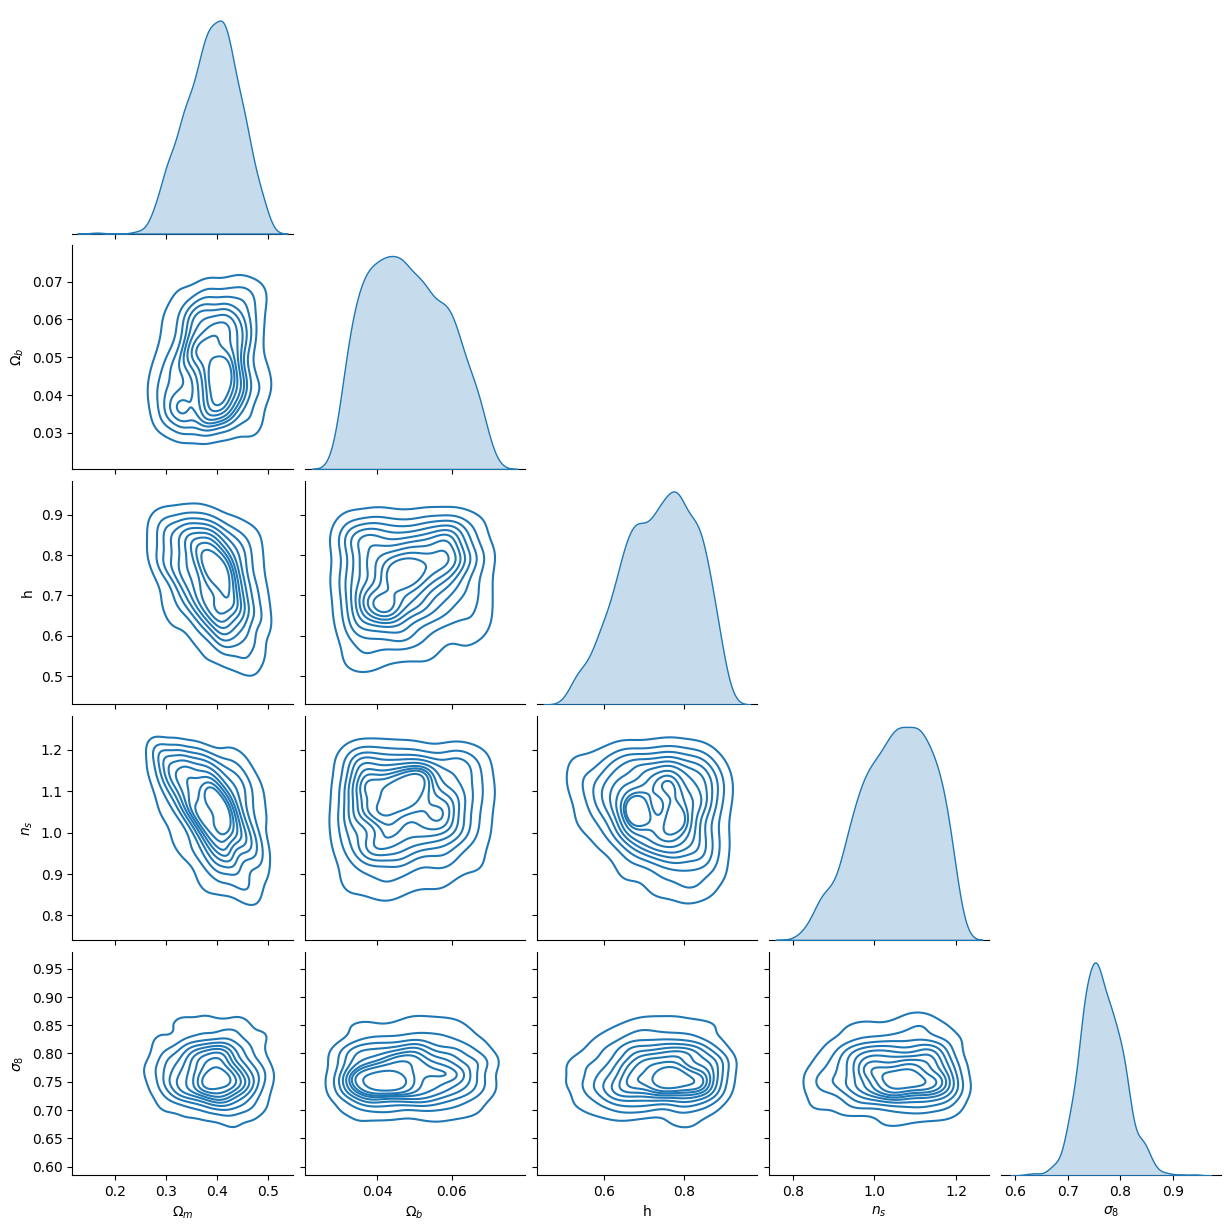

In [19]:
sns.pairplot(df_matt, kind="kde", corner=True)

In [5]:
np.loadtxt("/home/x-abairagi/ltu-cmass/params/latin_hypercube_params.txt").max(axis=0)

array([0.4999, 0.07  , 0.9   , 1.1999, 1.    ])